# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

   # used to aquire dataset
import acquire_telco as aq
   # used to prepare and clean the dataset
import prepare_telco as pp

   # make sure we can see the full scale of the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Aquistion

In [2]:
# The function get_telco_data() I created in the file acquire.py pulls the dataset straight from SQL
# UNLESS the data has already been downloaded as a .csv,
# in which case the function will pull the data straight from that file instead.

df = aq.get_telco_data()
df.info()

Reading from csv file...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-nul

# Data Preperation

In [3]:
# The function prep_telco() that I created in the file prepare.py takes in the Telco dataframe and cleans it
# It does this by dropping uneeded columns ['payment_type_id', 'internet_service_type_id', 'contract_type_id']
# I also made sure the function cleared any nulls from the dataset
# Lastly, I make it easier to manipulate the data by creating dummy column for each categorical column.

In [4]:
telco_df = df
df = pp.prep_telco(df)
df.head(2)

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0002-ORFBO,0,9,65.6,593.3,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
1,0003-MKNFE,0,9,59.9,542.4,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [5]:
# check for null values
df.isna().sum()

customer_id                              0
senior_citizen                           0
tenure                                   0
monthly_charges                          0
total_charges                            0
gender_Male                              0
partner_Yes                              0
dependents_Yes                           0
phone_service_Yes                        0
multiple_lines_No phone service          0
multiple_lines_Yes                       0
online_security_No internet service      0
online_security_Yes                      0
online_backup_No internet service        0
online_backup_Yes                        0
device_protection_No internet service    0
device_protection_Yes                    0
tech_support_No internet service         0
tech_support_Yes                         0
streaming_tv_No internet service         0
streaming_tv_Yes                         0
streaming_movies_No internet service     0
streaming_movies_Yes                     0
paperless_b

In [6]:
# rename columns for readability

df.rename(columns={'gender_Male': 'is_male',
                   'partner_Yes': 'married',
                   'dependents_Yes': 'children',
                   'phone_service_Yes': 'phone_service',
                   'multiple_lines_No phone service': 'no_phone_multiple_lines',
                   'multiple_lines_Yes': 'multiple_lines',
                   'online_security_No internet service': 'no_internet_online_security',
                   'online_security_Yes': 'online_security',
                   'online_backup_No internet service': 'no_internet_online_backup',
                   'online_backup_Yes': 'online_backup',
                   'device_protection_No internet service': 'no_internet_device_protection',
                   'device_protection_Yes': 'device_protection',
                   'tech_support_No internet service': 'no_internet_tech_support',
                   'tech_support_Yes': 'tech_support',
                   'streaming_tv_No internet service': 'no_internet_streaming_tv',
                   'streaming_tv_Yes': 'streaming_tv',
                   'streaming_movies_No internet service': 'no_internet_streaming_movies',
                   'streaming_movies_Yes': 'streaming_movies',
                   'paperless_billing_Yes': 'paperless_billing',
                   'churn_Yes': 'churn',
                   'contract_type_One year': 'one_year_contract',
                   'contract_type_Two year': 'two_year_contract',
                   'internet_service_type_Fiber optic': 'fiber_optic',
                   'internet_service_type_None': 'no_internet',
                   'payment_type_Credit card (automatic)': 'card_auto_pay',
                   'payment_type_Electronic check': 'electronic_check',
                   'payment_type_Mailed check': 'mailed_check'}, inplace=True)

# also drop customer id for training purposes
df = df.drop(columns=['customer_id'])

In [7]:
# check the sum of each column to see if there is any redundancy
# doing so shows that several columns made for the dummy list can be represented by just 1 column
# the 'no_internet' column
df = df.drop(columns=['no_internet_streaming_movies',
                      'no_internet_streaming_tv',
                      'no_internet_tech_support',
                      'no_internet_device_protection', 
                      'no_internet_online_backup',
                      'no_internet_online_security',
                      'no_phone_multiple_lines'])

df.head(3)
# now we can move forward to exploring the data with visuals and statistics

,senior_citizen,tenure,monthly_charges,total_charges,is_male,married,children,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,one_year_contract,two_year_contract,fiber_optic,no_internet,card_auto_pay,electronic_check,mailed_check
0,0,9,65.6,593.30,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,1
1,0,9,59.9,542.40,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,4,73.9,280.85,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0


# Exploratory Data Analysis and Statistical Testing

In [8]:
df.churn.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [9]:
# details on 
telco_df.contract_type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: contract_type, dtype: int64

In [10]:
# details on tenure
telco_df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

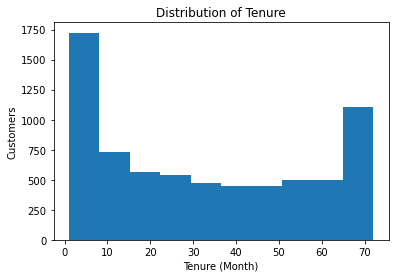

In [11]:
# distribution of tenure
plt.title('Distribution of Tenure')
plt.hist(x='tenure', data=df)
plt.xlabel('Tenure (Month)')
plt.ylabel('Customers')
plt.show()

In [12]:
# Two peaks, indicating two possible populations to explore
# Not a normal distribution


df.describe()
# This will give a few metrics to measure with when doing statistical exploration

,senior_citizen,tenure,monthly_charges,total_charges,is_male,married,children,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,one_year_contract,two_year_contract,fiber_optic,no_internet,card_auto_pay,electronic_check,mailed_check
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.504693,0.482509,0.298493,0.903299,0.421928,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.592719,0.265785,0.209329,0.239619,0.440273,0.216155,0.216297,0.336320,0.228100
std,0.368844,24.545260,30.085974,2266.771362,0.500014,0.499729,0.457629,0.295571,0.493902,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.491363,0.441782,0.406858,0.426881,0.496455,0.411650,0.411748,0.472483,0.419637
min,0.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# Explore the distribution of Total Charges
df.total_charges.describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: total_charges, dtype: float64

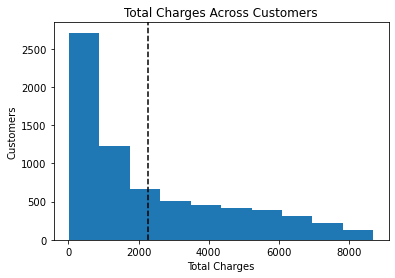

In [14]:
plt.title('Total Charges Across Customers')
plt.hist(x='total_charges', data=df)
plt.xlabel('Total Charges')
plt.ylabel('Customers')
plt.axvline(x=df['total_charges'].mean(), color='k', linestyle='dashed')
plt.show()

# Question 1 
#### What customers are most important to prevent churning?
- How long are customers that churn staying with us?
- What's their lifetime charges (total charges)?
- How do their total charges differ from those that did not churn?

In [15]:
# Let's take a closer look at accounts that churned to look for possible variables
churned_df = df[df.churn == 1]

# Verify changes and examine the distribution of total charges over tenure
churned_df.total_charges.describe()

count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: total_charges, dtype: float64

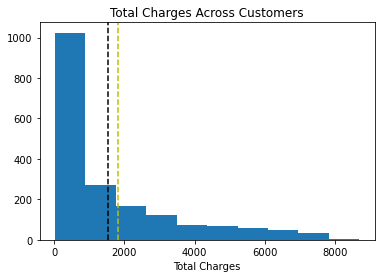

In [16]:
# Vizualize the distribution
plt.title('Total Charges Across Customers')
plt.hist(x='total_charges', data=churned_df)
plt.xlabel('Total Charges')
plt.axvline(x=churned_df['total_charges'].mean(), color='k', linestyle='dashed')
plt.axvline(x=churned_df['total_charges'].quantile(0.7), color='y', linestyle='dashed')
plt.show()

In [17]:
# There is a clear skew to the data, with the mean leaning heavily on the left of the graph
# Almost 70% of customers churned before reaching a lifetime value(LTV) of $1,800
churned_df.total_charges.quantile(0.7)

1800.9199999999983

- This seems like significant data from a business perspective, so we're going to invesigate further by seperating the bottom 70% of those who churned with the top 30% (with regards to total charges)

In [18]:
# Division of those churned accounts
bottom_70 = churned_df[churned_df.total_charges <= 1800.92]
top_30 = churned_df[churned_df.total_charges > 1800.92]

# Check distribution of the bottom 70%
bottom_70.total_charges.describe()

count    1308.000000
mean      481.136506
std       487.196050
min        18.850000
25%        78.762500
50%       271.550000
75%       810.325000
max      1789.250000
Name: total_charges, dtype: float64

In [19]:
# The lifetime value of these customers are low, averaging at just under $500
# How long did these accounts tenure with us?
bottom_70.tenure.describe()

count    1308.000000
mean        7.185015
std         7.894253
min         1.000000
25%         1.000000
50%         4.000000
75%        11.000000
max        61.000000
Name: tenure, dtype: float64

- The average tenure of these accounts is 7 months, a short time to be with Telco

In [20]:
# Show the distribution of LTV for the top 30% of customers that churned.
top_30.total_charges.describe()

count     561.000000
mean     3981.462299
std      1667.921308
min      1808.700000
25%      2550.900000
50%      3520.750000
75%      5224.350000
max      8684.800000
Name: total_charges, dtype: float64

In [21]:
# The value of these accounts are much higher, with an average LTV of almost $4,000 (8x as much as the lower 70%)
# Logically their tenure will be longer as well
top_30.tenure.describe()

count    561.000000
mean      43.146168
std       14.844432
min       18.000000
25%       31.000000
50%       41.000000
75%       55.000000
max       72.000000
Name: tenure, dtype: float64

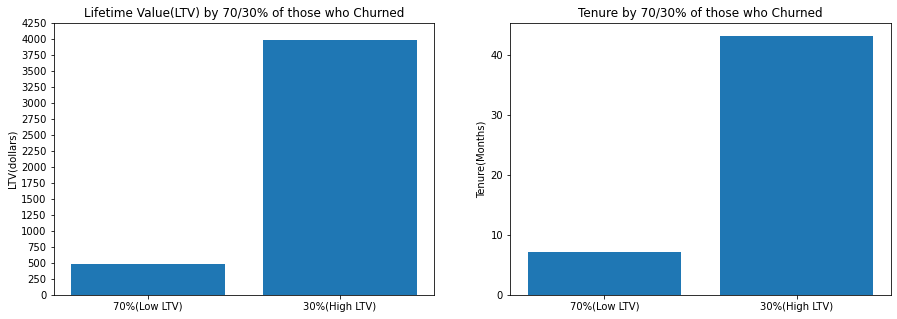

In [22]:
bot_charges = bottom_70.total_charges.mean()
top_charges = top_30.total_charges.mean()
bot_tenure = bottom_70.tenure.mean()
top_tenure = top_30.tenure.mean()

# Vizualize these side by side
plt.figure(figsize=[15, 5])
# Left Plot visualizes value of each population
plt.subplot(1, 2, 1)
plt.bar([1, 2], [bot_charges, top_charges])
plt.yticks(range(0,4500,250))
plt.xticks([1, 2] ,['70%(Low LTV)', '30%(High LTV)'])
plt.ylabel('LTV(dollars)')
plt.title('Lifetime Value(LTV) by 70/30% of those who Churned')


# Right Plot v
plt.subplot(1, 2, 2)
plt.bar([1, 2], [bot_tenure, top_tenure])
plt.xticks([1, 2], ['70%(Low LTV)', '30%(High LTV)'])
plt.ylabel('Tenure(Months)')
plt.title('Tenure by 70/30% of those who Churned')

plt.show()

- The graph shows the difference in average lifetime value between these two populations, where 70% of those who churn only averaged 500 dollars during their entie tenure with Telco, which itself averaged at 7 months.  Respectively, the top 30% of churned accounts average just under 4,000 dollars during their tenure, which averaged at 43 months.  Considering the majority contribution to revenue from the top 30%, I would suggest we focus on finding the key driver for churn from the bottom 70% in an effort to keep those accounts longer and move them to the High LTV category. 

# Question 2 - Deeper Look
#### What were the services that those higher value accounts looked for, and do they differ from their lower value counterparts?
- These will more than likely be good indicators for churn

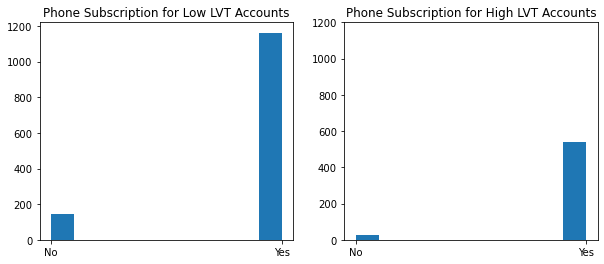

In [23]:
# First, lets compare phone service.

plt.figure(figsize=[10, 4])
# Left Plot visualizes value of each population
plt.subplot(1, 2, 1)
plt.hist(bottom_70.phone_service, rwidth=2)
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks(range(0,1300,200))
plt.title('Phone Subscription for Low LVT Accounts')

plt.subplot(1, 2, 2)
plt.hist(top_30.phone_service)
plt.xticks([0, 1], ['No', 'Yes'])
plt.yticks(range(0,1300,200))
plt.title('Phone Subscription for High LVT Accounts')


plt.show()

In [24]:
bot = (bottom_70.multiple_lines.sum()/bottom_70.phone_service.sum())
top = (top_30.multiple_lines.sum()/top_30.phone_service.sum())

print(f'Low LTV (70% of Churned Accounts): {bot:.2%}')
print(f'Hight LTV (30% of Churned Accounts): {top:.2%}')

Low LTV (70% of Churned Accounts): 37.95%
Hight LTV (30% of Churned Accounts): 76.16%


- Looking at the percentage of phone users that have multiple lines in both High and Low LTV, there is a notable difference.  The portion of Low LTV phone users with multiple lines is 37.95%.  Compared to double that for the High LTV population, at 76.16%


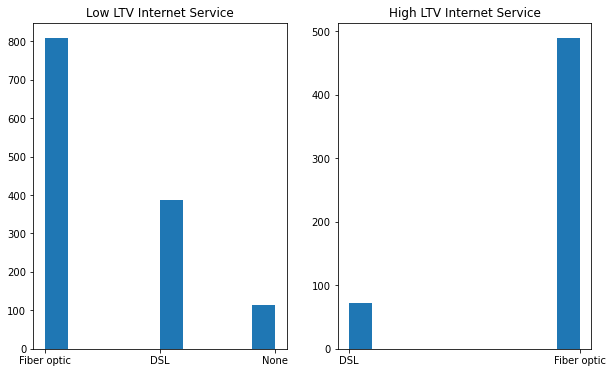

In [25]:
# First, I need to set up some variables
# This gives me the same data, but better fitted to graph the next few categories
telco_df.total_charges = telco_df.total_charges.replace(' ', 0).astype(float)
telco_df = telco_df[telco_df.tenure != 0]
churned_df = telco_df[telco_df.churn == 'Yes']
bottom_70_2 = churned_df[churned_df.total_charges <= 1800.92]
top_30_2 = churned_df[churned_df.total_charges > 1800.92]



# Now lets look at internet statistics, starting with service type
plt.figure(figsize = [10, 6])

plt.subplot(1, 2, 1)
plt.hist(bottom_70_2.internet_service_type)
plt.title('Low LTV Internet Service')

plt.subplot(1, 2, 2)
plt.hist(top_30_2.internet_service_type)
plt.title('High LTV Internet Service')

plt.show()

In [54]:
# What internet features attracted those high value customers?


# Low LTV 
total_internet_bot = bottom_70_2[bottom_70_2.internet_service_type != 'None'].internet_service_type.count()

results =[]

os = (bottom_70['online_security'].sum()/total_internet_bot)*100
ob = (bottom_70['online_backup'].sum()/total_internet_bot)*100
dp = (bottom_70['device_protection'].sum()/total_internet_bot)*100
ts = (bottom_70['tech_support'].sum()/total_internet_bot)*100
stv = (bottom_70['streaming_tv'].sum()/total_internet_bot)*100
sm = (bottom_70['streaming_movies'].sum()/total_internet_bot)*100
    
data ={
    'sample': 'Low LTV',
    'online_security': round(os, 2),
    'online_backup': round(ob, 2),
    'device_protection': round(dp, 2),
    'tech_support': round(ts, 2),
    'streaming_tv': round(stv, 2),
    'streaming_movies': round(sm, 2)
}

results.append(data)

# High LTV
total_internet_top = top_30_2[top_30_2.internet_service_type != 'None'].internet_service_type.count()


os = (top_30['online_security'].sum()/total_internet_top)*100
ob = (top_30['online_backup'].sum()/total_internet_top)*100
dp = (top_30['device_protection'].sum()/total_internet_top)*100
ts = (top_30['tech_support'].sum()/total_internet_top)*100
stv = (top_30['streaming_tv'].sum()/total_internet_top)*100
sm = (top_30['streaming_movies'].sum()/total_internet_top)*100
    
data ={
    'sample': 'High LTV',
    'online_security': round(os, 2),
    'online_backup': round(ob, 2),
    'device_protection': round(dp, 2),
    'tech_support': round(ts, 2),
    'streaming_tv': round(stv, 2),
    'streaming_movies': round(sm, 2)
}

results.append(data)

temp_df = pd.DataFrame(results)
temp_df.transpose()

,0,1
sample,Low LTV,High LTV
online_security,12.3,26.38
online_backup,19.67,51.34
device_protection,21.59,51.16
tech_support,12.47,28.7
streaming_tv,34.73,71.12
streaming_movies,34.73,71.84


### Takeaways Thus Far...

#### Our higher value customers that have a longer tenure with Telco are more likely to have the following features to their accounts:
- Multiple phone lines
- Almost certainly have internet
- More likely to have online security feature as well as device protection
- Much more likely to have streaming TV and Movies

#### At glance, I would say these are good idicators to test, but I would also infer that these High LTV accounts with these features are also likely to be married or have children.  


# Question 3 - Household

- Will the customers household be a good indicator of churn?
- Let's also verify our other suspicions


In [55]:
df.head()

,senior_citizen,tenure,monthly_charges,total_charges,is_male,married,children,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn,one_year_contract,two_year_contract,fiber_optic,no_internet,card_auto_pay,electronic_check,mailed_check
0,0,9,65.6,593.30,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,1
1,0,9,59.9,542.40,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,4,73.9,280.85,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0
3,1,13,98.0,1237.85,1,1,0,1,0,0,1,1,0,1,1,1,1,0,0,1,0,0,1,0
4,1,3,83.9,267.40,0,1,0,1,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1


In [ ]:
# almost done prepping the data,
# now to split the data into our train, validate, and test samples

train, test = train_test_split(df, 
                               train_size = 0.8,
                               random_state=1313)

train, validate = train_test_split(train,
                                  train_size = 0.7,
                                  random_state=1313)

train.shape, validate.shape, test.shape

# Modeling to fit the Data

# Model Evaluation

# Finding and Key Takeaways